# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [306]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.preprocessing import MultiLabelBinarizer

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EXPLORE PORTFOLIO

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# how many rows and columns?
portfolio.shape # 10 rows and 6 columns

(10, 6)

In [5]:
# how many reward types and how many of each reward?
portfolio['reward'].value_counts() # 5 reward types

5     3
10    2
2     2
0     2
3     1
Name: reward, dtype: int64

### Offer type

In [6]:
# what are the offer_types and how many of each?
print(portfolio['offer_type'].value_counts())
portfolio.sort_values('offer_type')

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


offer_types of 'bogo' have the highest reward. The 'bogo' category has all the highest rewards (10's) and the second highest (5's, which is also found in discounts). Also note that there are equal amount of discount and BOGO offers (each have 4)

Looking at this data, it might be best to one hot encode the column:

In [7]:
offer_temp = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, offer_temp], axis = 1, sort = False)
portfolio

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0


### Difficulty column

In [8]:
print('Highest Difficulty: ',max(portfolio['difficulty']))
print('Shortest Difficulty: ' ,min(portfolio['difficulty']))
# what are the difficulty levels? How many per difficulty level
portfolio['difficulty'].value_counts()

Highest Difficulty:  20
Shortest Difficulty:  0


10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64

In [9]:
# what are the other features in the 0 difficulty rows?
portfolio[portfolio['difficulty'] == 0]

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1


In [10]:
# what are the other features in the 0 difficulty rows? for each level of difficulty
# sort on difficulty column to see df better related to difficulty
portfolio.sort_values(by = ['difficulty','duration'])

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


A difficulty of 0 mean a offer_type of 'informational'. No other difficulties have an offer_type of 'informational'.

Also note that the highest difficulty does not have the highest reward.  Highest reward has a difficulty of 10, one level lower than 20. These also have shorter durations. So is it possible that a lower duration makes a more valuable reward?

### Duration column

In [11]:
print('Longest Duration: ',max(portfolio['duration']))
print('Shortest Duration: ' ,min(portfolio['duration']))

# what are the durations levels? how many per duration?
portfolio['duration'].value_counts()

Longest Duration:  10
Shortest Duration:  3


7     4
10    2
5     2
4     1
3     1
Name: duration, dtype: int64

In [12]:
portfolio.sort_values(by = ['duration', 'difficulty'])

,reward,channels,difficulty,duration,offer_type,id,bogo,discount,informational
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


The duration column is in days, but it should be converted to hours. Since the transcript has a time based column in hours, these should be consistent

In [13]:
portfolio['duration'] = portfolio['duration']*24

### Id

In [247]:
# are there more than 1 Id's in the dataset?
portfolio['id'].value_counts().sort_values(ascending = False)

fafdcd668e3743c1bb461111dcafc2a4    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
2906b810c7d4411798c6938adc9daaa5    1
f19421c1d4aa40978ebb69ca19b0e20d    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
5a8bc65990b245e5a138643cd4eb9837    1
ae264e3637204a6fb9bb56bc8210ddfd    1
3f207df678b143eea3cee63160fa8bed    1
Name: id, dtype: int64

### Channels

In [17]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [19]:
# looks like this column contains lists of varying lengths
# hot encode the channels column so each item in list is 1 or 0
mlb = MultiLabelBinarizer(sparse_output=True)
portfolio_v1 = portfolio.copy()

portfolio_v1 = portfolio_v1.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(portfolio_v1.pop('channels')),
                index=portfolio_v1.index,
                columns=mlb.classes_))

# uncomment if want to add back the lists to dataframe
#df['channels'] = portfolio['channels']

In [20]:
portfolio_v1

,reward,difficulty,duration,offer_type,id,bogo,discount,informational,email,mobile,social,web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


### Reward column

In [248]:
portfolio_v1['reward'].value_counts()

5     3
10    2
2     2
0     2
3     1
Name: reward, dtype: int64

In [249]:
portfolio_v1.sort_values('reward')

,reward,difficulty,duration,offer_type,id,bogo,discount,informational,email,mobile,social,web
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1


In [293]:
# make a function that performs all data transformation steps
def portfolio_transform(portfolio):
    
    # hot encode offer_type
    offer_temp = pd.get_dummies(portfolio['offer_type'])
    portfolio = pd.concat([portfolio, offer_temp], axis = 1, sort = False)
    
    # convert duration to hours for consistency with other datasets
    portfolio['duration'] = portfolio['duration']*24
    
    # hot encode channels
    mlb = MultiLabelBinarizer(sparse_output=True)
    portfolio = portfolio.join(
                pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(portfolio.pop('channels')),
                    index=portfolio.index,
                    columns=mlb.classes_))
    
    return portfolio

# EXPLORE PROFILE

In [24]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [25]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


First thoughts:
- Explore gender column to see if more than M, F, None
- Look at range of ages. First is 118, which is probably not real
- Duplicates for id?
- Need to potentiall change became_member_on to date type
- How many NaN's in income? Range?
- How are these all collected?

### Id

In [250]:
# see if all unique Ids
profile['id'].value_counts().sort_values(ascending = False)

267e47de94fd46b1afa96dea1c9d3cbf    1
2eb115563ebe4784986c3af78a41ea79    1
adf9a0caa4494437bee5b2700b79207a    1
6eb244501c7641c58587846c8812e0b5    1
53f9276cd0f24fe08a42f99ae60ba2b4    1
                                   ..
84f92efc819047ec88e3544570c8da30    1
9eb812054d564bdba180dc365f186e23    1
1f5c961416e64c5d88098b02b1bdf246    1
205d1ace508649fab7429043d9203f6b    1
4cfaa26c8d4f4fabaf9017861d152634    1
Name: id, Length: 17000, dtype: int64

### Gender

In [27]:
# since see a null in the head above, how many nulls?
sum(profile['gender'].isnull())

# proportion of nulls
sum(profile['gender'].isnull())/len(profile.index)

0.12794117647058822

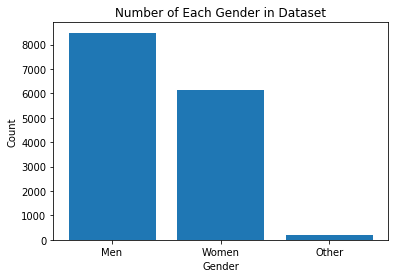

,gender,count,proportion
0,M,8484,0.572277
1,F,6129,0.413423
2,O,212,0.014300


In [28]:
# what are the remaining gender?
gender_value_counts = profile['gender'].value_counts().rename_axis('gender').reset_index(name = 'count')

# M proportion of rows with values
m_prop = len(profile[profile['gender'] == 'M']['gender']) / sum(profile['gender'].notnull())

# F proportion of rows with values
f_prop = len(profile[profile['gender'] == 'F']['gender']) / sum(profile['gender'].notnull())

# O proportion of rows with values
o_prop = len(profile[profile['gender'] == 'O']['gender']) / sum(profile['gender'].notnull())


gender_prop_list = [m_prop, f_prop, o_prop]

# proportions add up to 1? validation for calc done
sum(gender_prop_list)

# add to df and output df as a table view for 
gender_value_counts['proportion'] = gender_prop_list

# make a bar chart representation of the dataframe
gender_value_counts


data = gender_value_counts['count']
labels = ['Men', 'Women','Other']
plt.xticks(range(len(data)), labels)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Number of Each Gender in Dataset')
plt.bar(range(len(data)), data) 
plt.show()

# show table
gender_value_counts

Mostly 'M' and 'F'. There are some 'O'. There is more than a 50-50 proportion of men to women, so this is something to be aware of during later analysis

Analyze other features in relation with gender:

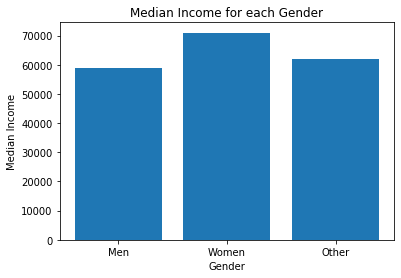

,gender,count,proportion,median income,avg income
0,M,8484,0.572277,59000.0,61194.601603
1,F,6129,0.413423,71000.0,71306.412139
2,O,212,0.014300,62000.0,63287.735849


In [29]:
# median income for each group

# M median income
m_med_income = profile[profile['gender'] == 'M']['income'].median()

# F median income
f_med_income = profile[profile['gender'] == 'F']['income'].median()

# O median income
o_med_income = profile[profile['gender'] == 'O']['income'].median()

gender_med_income_list = [m_med_income, f_med_income, o_med_income]
gender_value_counts['median income'] = gender_med_income_list

# M avg income
m_avg_income = profile[profile['gender'] == 'M']['income'].mean()

# F avg income
f_avg_income = profile[profile['gender'] == 'F']['income'].mean()

# O median income
o_avg_income = profile[profile['gender'] == 'O']['income'].mean()

gender_avg_income_list = [m_avg_income, f_avg_income, o_avg_income]
gender_value_counts['avg income'] = gender_avg_income_list

# make a bar chart to represent the dataframe
data = gender_value_counts['median income']
labels = ['Men', 'Women','Other']
plt.xticks(range(len(data)), labels)
plt.xlabel('Gender')
plt.ylabel('Median Income')
plt.title('Median Income for each Gender')
plt.bar(range(len(data)), data) 
plt.show()

# display dataframe for comparisons between genders
gender_value_counts

women have the highest median salary, men the lowest

look at income per gender distributions using bar and violin plots

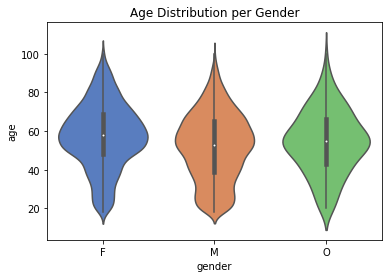

In [30]:
ax = plt.axes()
sns.violinplot(x="gender", y="age", data=profile, palette="muted")
ax.set_title('Age Distribution per Gender');

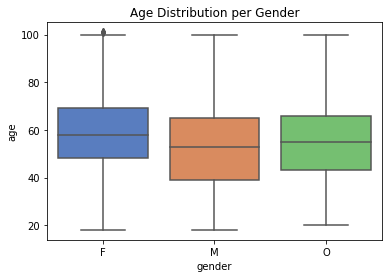

In [31]:
ax = plt.axes()
sns.boxplot(x="gender", y="age", data=profile, palette="muted")
ax.set_title('Age Distribution per Gender');

### Age

Summary statistics for age:
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

Top 10 user ages:
118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64



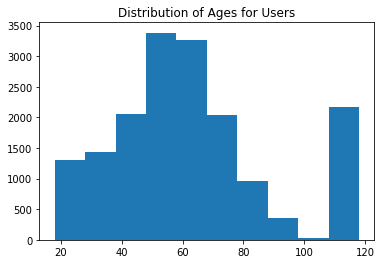

In [34]:
plt.hist(profile['age']);
plt.title('Distribution of Ages for Users');
print('Summary statistics for age:')
print(profile['age'].describe())
print()
print('Top 10 user ages:')
print(profile['age'].value_counts().head(10))
print()

There is a large number of people with an age above 100. These ages are probably not correct or an error. 

How many people are over 100 years old?

In [251]:
print('Number of People over 100: ',len(profile[profile['age'] > 100]))
print('Proportion of People over 100: ',round(len(profile[profile['age'] > 100]) / len(profile.index),2))

Number of People over 100:  2180
Proportion of People over 100:  0.13


In [252]:
print('What are the different ages of people who are over 100:')
profile[profile['age'] > 100]['age'].value_counts()

What are the different ages of people who are over 100:


118    2175
101       5
Name: age, dtype: int64

Now let's take a look at some of the rows where age is greater than 100:

In [253]:
profile[profile['age'] > 100].head()

,gender,age,id,became_member_on,income,new_became_member_on,Age_Gen,member_len
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,Silent,1293
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,Silent,778
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,Silent,1120
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,2017-09-25,Silent,1068
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,2017-10-02,Silent,1061


The top 5 rows all have NaN salaries and no gender.

So, how many null salaries are there for peope over 100?

In [254]:
# how many have null salaries? 
print('Proportion of people who are over 100 years old and have null salaries:')
round(profile[profile['age'] > 100]['income'].isnull().sum() / \
    len(profile[profile['age'] > 100]['age'].index), 5)

Proportion of people who are over 100 years old and have null salaries:


0.99771

And how many have no gender?

In [255]:
# how many have no gender? 
print('Proportion of people who are over 100 years old and have null genders:')
round((profile[profile['age'] > 100]['gender'].isnull().sum() / \
    len(profile[profile['age'] > 100]['gender'].index)),5)

Proportion of people who are over 100 years old and have null genders:


0.99771

It appears the proportions are the same, so people with no gender also have null salaries. 

Now let's look at genders for people over 100 and have null income to verify this:

In [256]:
profile[(profile['age'] > 100) & (profile['income'].isnull())]['gender'].value_counts()

Series([], Name: gender, dtype: int64)

The code above returned an empty value counts output, which means there were no genders for rows where salary was null (at least in this specific dataset)

Therefore, the only information that is useful is the became member on column. What does this look like for people with ages over 100 and have null values for other fields?

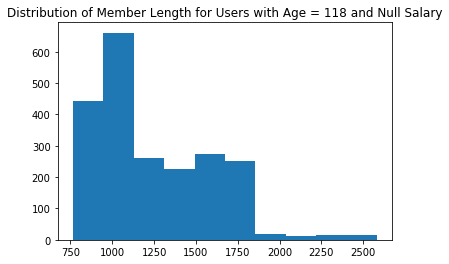

In [262]:
plt.hist(profile[(profile['age'] > 100) & (profile['income'].isnull())]['member_len'], bins = 10);
plt.title('Distribution of Member Length for Users with Age = 118 and Null Salary');

Members with null salaries and age = 118 appear to have valid data for member length. It may be appropriate to keep these in the dataset and to analyze user item interactions. However, age should not be 118 since it may still appear to be a reasonable value to someone working with the data or reviewing. Change this to 200 to represent missing values. 

In [290]:
profile['age'] = profile['age'].apply(lambda x: np.NaN if x == 118 else x)

In [291]:
profile[profile['age'] == np.NaN]

,gender,age,id,became_member_on,income,new_became_member_on


Now, let's explore the data where age is over 100, but have salary and gender information:

In [36]:
profile[(profile['age'] > 100)& (profile['income'].notnull())]

,gender,age,id,became_member_on,income
1556,F,101,4d2ccfcbbebf4bd9baf4b7e433d0e288,20171004,43000.0
4100,F,101,d2fdc2be8ab64e4ba04830d441e53fd5,20150526,99000.0
14846,F,101,e0ea90ddd2f147e082d21e97f51ec1b1,20171109,56000.0
15800,F,101,047ad0135cfe4c0ea5ba019da4de9c52,20170309,59000.0
16864,F,101,1593d617fac246ef8e50dbb0ffd77f5f,20171127,82000.0


For people over 100 who have non-null salaries and reported genders, the information appears relevant. There are only 5 rows where these rules apply, so we can keep these in the data. And not make any adjustments

After looking at age, it would be interesting to see what generation each user belongs to. Many studies are done based on age generations, so would be good to have this derived feature.

In [39]:
# generation calculations
year_curr = datetime.today().year
boomer_age_upper = year_curr - 1946
boomer_age_lower = year_curr - 1964
genx_age_upper = year_curr - 1965
genx_age_lower= year_curr -1980
millenial_age_upper = year_curr - 1981
millenial_age_lower = year_curr - 1996
genz_age_upper = year_curr - 1997
genz_age_lower = year_curr - year_curr
silent_age_upper = year_curr - 1928
silent_age_lower = year_curr - 1945

In [128]:
# using date of birth cutoffs, create a new column that states generations
profile.loc[profile['age'] >= silent_age_lower, 'Age_Gen'] = 'Silent'
profile.loc[((profile['age'] >= boomer_age_lower) & \
              (profile['age'] <= boomer_age_upper)), 'Age_Gen'] = 'Boomers'
profile.loc[((profile['age'] >= genx_age_lower) & \
              (profile['age'] <= genx_age_upper)), 'Age_Gen'] = 'Generation X'
profile.loc[((profile['age'] >= millenial_age_lower) & \
              (profile['age'] <= millenial_age_upper)), 'Age_Gen'] = 'Millenials'
profile.loc[((profile['age'] >= genz_age_lower) & \
              (profile['age'] <= genz_age_upper)), 'Age_Gen'] = 'Generation Z'

In [41]:
profile.head(2)

,gender,age,id,became_member_on,income,Age_Gen
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,Generation X
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,Silent


In [42]:
# how many people per generation
profile['Age_Gen'].value_counts()

Boomers         5528
Generation X    4388
Millenials      2363
Silent          1809
Generation Z     737
Name: Age_Gen, dtype: int64

## became_member_on

the .info() function showed that this column is an integer. want to change to datetime

In [276]:
# change to datetime. make new column in dataframe for now
profile['new_became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [160]:
# verify change
profile.info() # should now be datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   gender                14825 non-null  object        
 1   age                   17000 non-null  int64         
 2   id                    17000 non-null  object        
 3   became_member_on      17000 non-null  int64         
 4   income                14825 non-null  float64       
 5   new_became_member_on  17000 non-null  datetime64[ns]
 6   Age_Gen               17000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 929.8+ KB


In [45]:
# see nulls for this column
profile['new_became_member_on'].isnull().sum()

0

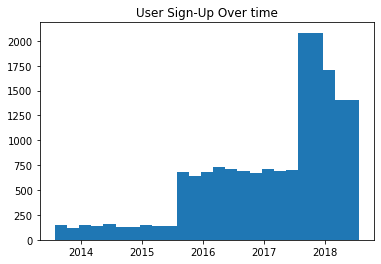

In [130]:
# plot over time to see when people joined program and when there were the most
plt.hist(profile['new_became_member_on'], bins=25)
plt.title('User Sign-Up Over time')
plt.show()

The histogram above shows that user sign ups over time has significant increases in 2016 and 2018. 

It might be more useful to calculate years as a member, and use this value to recommendations. User tastes may change over time, or just user behavior:

In [212]:
# calculate how long sumone has been a member based on join date
profile['member_len'] = (datetime.now() - profile['new_became_member_on']).dt.days

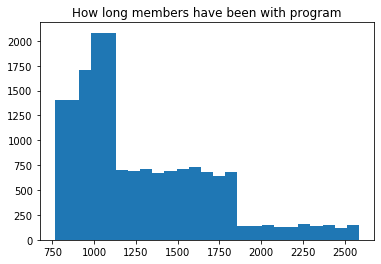

In [214]:
# plot over time to see when people joined program and when there were the most
plt.hist(profile['member_len'], bins=25)
plt.title('How long members have been with program')
plt.show()

## income


some exploration was done in then Gender section, but will explore this feature a little more:

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

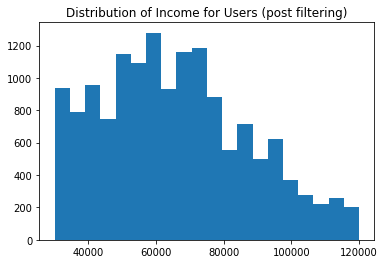

In [46]:
plt.hist(profile_v2['income'], bins = 20);
plt.title('Distribution of Income for Users (post filtering)');
profile_v2['income'].describe()

Mostly centered around \\$65,000, since meain is \\$65k and median is \\$64k

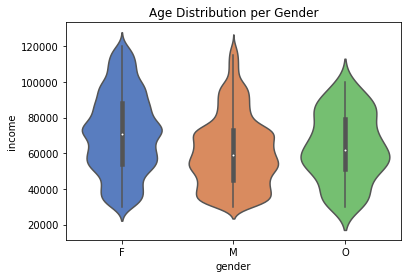

In [287]:
ax = plt.axes()
sns.violinplot(x="gender", y="income", data=profile, palette="muted")
ax.set_title('Age Distribution per Gender');

Appears men in the cusomter profile data tend is skewed towards the lower side of the income distribution, and for other genders is more evenly distributed.

In [283]:
# make a function with all transformations

def profile_transform(profile):
    # change people with age = 118 to age = 200 since most likely incorrect age entered
    profile['age'] = profile['age'].apply(lambda x: np.NaN if x == 118 else x)

    # make a generation column based on age
    # generation calculations
    year_curr = datetime.today().year
    boomer_age_upper = year_curr - 1946
    boomer_age_lower = year_curr - 1964
    genx_age_upper = year_curr - 1965
    genx_age_lower= year_curr -1980
    millenial_age_upper = year_curr - 1981
    millenial_age_lower = year_curr - 1996
    genz_age_upper = year_curr - 1997
    genz_age_lower = year_curr - year_curr
    silent_age_upper = year_curr - 1928
    silent_age_lower = year_curr - 1945

    # using date of birth cutoffs, create a new column that states generations
    profile.loc[profile['age'] >= silent_age_lower, 'Age_Gen'] = 'Silent'
    profile.loc[((profile['age'] >= boomer_age_lower) & \
                  (profile['age'] <= boomer_age_upper)), 'Age_Gen'] = 'Boomers'
    profile.loc[((profile['age'] >= genx_age_lower) & \
                  (profile['age'] <= genx_age_upper)), 'Age_Gen'] = 'Generation X'
    profile.loc[((profile['age'] >= millenial_age_lower) & \
                  (profile['age'] <= millenial_age_upper)), 'Age_Gen'] = 'Millenials'
    profile.loc[((profile['age'] >= genz_age_lower) & \
                  (profile['age'] <= genz_age_upper)), 'Age_Gen'] = 'Generation Z'



    # change column to date time. make new column
    profile['new_became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    
    # create a new column that contains how long a person has been a customer
    profile['member_len'] = (datetime.now() - profile['new_became_member_on']).dt.days
    
    return profile

# EXPLORE TRANSCRIPT

In [47]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [48]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Event

In [49]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Value

In [50]:
transcript['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

In [51]:
# make the column that contains dictionaries into separate columns
transcript = transcript['value'].apply(pd.Series)

In [52]:
transcript.head(1)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN


There are 4 possible values that are in the the 'value' column, which is a column with dictionaries:
- offer id
- amount
- offer_id
- reward

'offer id' and 'offer_id' seem similar, so let's compare the two columns:

In [53]:
# are there instances where there are both 'offer id' and 'offer_id'
transcript[(transcript['offer id'].notnull()) & (test['offer_id'].notnull())] #none

,offer id,amount,offer_id,reward


It does not look like there are rows where there are values for both 'offer_id; and 'offer id'. Therefore let's combine these two columns

In [307]:
# there are two similar columns: 'offer id' and 'offer_id'
# combine the two columns to have only one column with these values
transcript['offer_id2'] = transcript['offer_id']
transcript['offer_id2'].fillna(transcript['offer id'], inplace = True)
transcript.drop(['offer id', 'offer_id'], axis = 1, inplace = True)
# rename column to 'offer_id'
transcript.rename(columns = {'offer_id2': 'offer_id'}, inplace = True)

Now let's look at amount:

In [ ]:
# how many nulls are there when there in the amount column when there is a value in the reward column
transcript[(transcript['reward'].notnull())]['amount'].isnull().value_counts()

In [310]:
# exploring transaction more
transcript[transcript['amount'].notnull()].head()

,person,event,value,time,amount,reward,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,NaN,NaN


In [311]:
transcript[(transcript['event'] == 'transaction') & (transcript['amount'] == 0)]['amount'].isnull().sum()

0

In [312]:
(transcript['amount'] == 0).sum()

0

Explore the 'amount' column:

Looks like if Event = transaction, then there will be an amount.

This is because when amount is null, there is only the values of 'offer received', 'offer viewed', 'offer completed'.

Also, because all events with transaction as the value, there are no nulls and have values greater than 0.

In [313]:
# when event = transaction, are there any nulls in amount
transcript[transcript['event'] == 'transaction']['amount'].isnull().sum()

# what are the event data values when amount is null
transcript[transcript['amount'].isnull()]['event'].value_counts()
# transaction is not present

# also see if there are any amounts = 0. 
(transcript['amount'] == 0).sum()
# less than 0?
(transcript['amount'] < 0).sum()
# none, therefore either have a value greater than 0 or null

0

### Time

In [314]:
# what is the max value in the time column. time is in hours
print('Max time in hours : ', transcript.time.max())
print('Max time in days  : ', transcript.time.max()/24)

Max time in hours :  714
Max time in days  :  29.75


In [315]:
# what is the data type for the time column?
transcript['time'].dtype

dtype('int64')

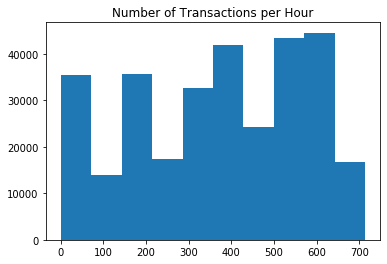

In [316]:
#what is the distribution of time?

plt.hist(transcript['time'], bins=10)
plt.title('Number of Transactions per Hour')
plt.show()

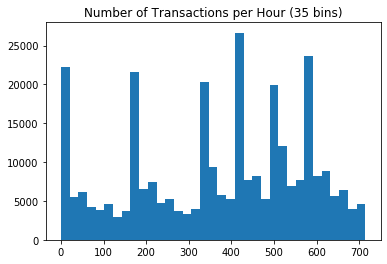

In [317]:
# increase bin size in the histogram
plt.hist(transcript['time'], bins=35)
plt.title('Number of Transactions per Hour (35 bins)')
plt.show()

In [318]:
transcript[transcript['time'] == 0]['event'].value_counts()

offer received     12650
offer viewed        2072
transaction          633
offer completed      206
Name: event, dtype: int64

Are there days where offer viewed, transaction, or offer completed is the highest? Maybe people who complete offer on same day it is received are more valuable?


Or maybe....people with the shortest (viewed - received) are the most valuable since they look at it the quickest. Maybe consider their time from offer viewed to transaction or offer viewed to offer completed?

In [319]:
# see all time values for 'offer received' values
transcript[transcript['event'] == 'offer received']['time'].value_counts()

transcript[transcript['event'] == 'offer received']['time'].value_counts().index.sort_values()/24

Float64Index([0.0, 7.0, 14.0, 17.0, 21.0, 24.0], dtype='float64')

In [321]:
# what are the value of the peaks in the distribution?
transcript['time'].value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

In [320]:
#how many vales are there?
len(transcript['time'].value_counts()) #120

120

In [47]:
# see the value counts for time and see which ones are the peaks
transcript['time'].value_counts().values # there are 6 values that are much larger than the rest

array([17030, 17015, 16822, 16302, 16150, 15561,  3583,  3514,  3484,
        3222,  3153,  3146,  3017,  2937,  2908,  2823,  2783,  2739,
        2690,  2659,  2655,  2591,  2585,  2569,  2506,  2465,  2422,
        2406,  2375,  2367,  2306,  2296,  2225,  2215,  2212,  2194,
        2192,  2174,  2132,  2062,  2017,  2016,  2015,  2009,  2000,
        1995,  1975,  1969,  1961,  1943,  1934,  1928,  1921,  1896,
        1892,  1891,  1861,  1859,  1844,  1842,  1801,  1798,  1792,
        1754,  1732,  1713,  1668,  1665,  1650,  1630,  1619,  1611,
        1610,  1599,  1599,  1595,  1565,  1551,  1519,  1487,  1486,
        1433,  1428,  1384,  1373,  1351,  1338,  1326,  1323,  1308,
        1294,  1260,  1260,  1260,  1248,  1235,  1206,  1199,  1193,
        1175,  1168,  1130,  1115,  1106,  1104,  1073,  1048,  1034,
        1031,  1010,   983,   968,   968,   955,   952,   940,   938,
         914,   910,   894], dtype=int64)

In [61]:
transcript['time'].value_counts().head(6)

408    17030
576    17015
504    16822
336    16302
168    16150
0      15561
Name: time, dtype: int64

In [322]:
# see what kind of events are for each time value that is very high
for i in enumerate(transcript['time'].value_counts().head(6).index.tolist()):
    print('Value Counts for Time = ', i[1])
    print(transcript[transcript['time'] == i[1]]['event'].value_counts())
    print()

Value Counts for Time =  408
offer received     12778
offer viewed        2210
transaction         1395
offer completed      647
Name: event, dtype: int64

Value Counts for Time =  576
offer received     12765
offer viewed        2152
transaction         1408
offer completed      690
Name: event, dtype: int64

Value Counts for Time =  504
offer received     12704
offer viewed        2153
transaction         1351
offer completed      614
Name: event, dtype: int64

Value Counts for Time =  336
offer received     12711
offer viewed        2103
transaction         1060
offer completed      428
Name: event, dtype: int64

Value Counts for Time =  168
offer received     12669
offer viewed        2120
transaction          994
offer completed      367
Name: event, dtype: int64

Value Counts for Time =  0
offer received     12650
offer viewed        2072
transaction          633
offer completed      206
Name: event, dtype: int64



For each of the 6 time values that have a large number of events, "offer recevied" is a large proportion of the events. Let's see what events would look like without offer recevied:

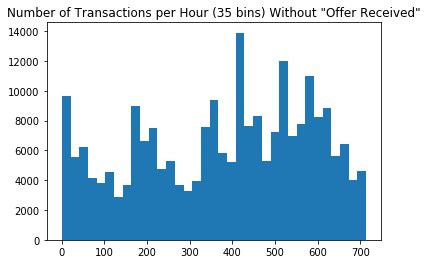

In [323]:
# drop offer received to see distribution of other events
plt.hist(transcript[transcript['event'] != \
                       'offer received']['time'], bins=35)
plt.title('Number of Transactions per Hour (35 bins) Without "Offer Received"')
plt.show()

Better yet, let's see the distribution for each 'event':

What is the distribution for each event?



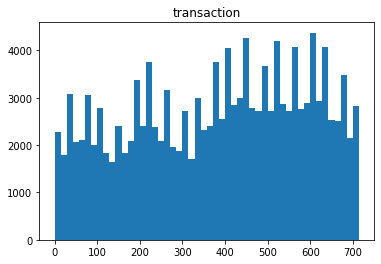

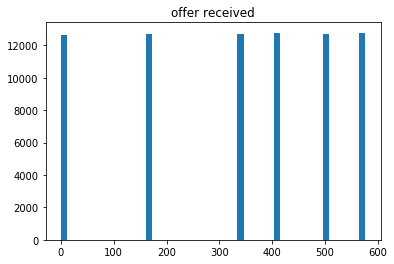

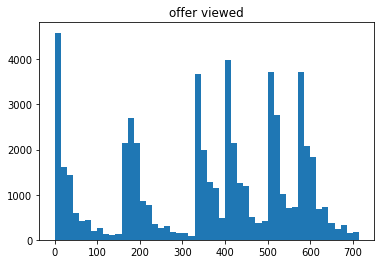

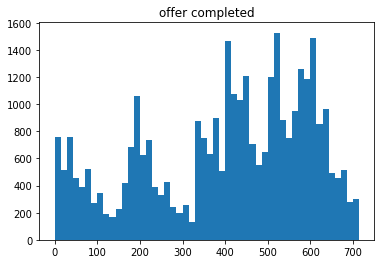

In [324]:
print('What is the distribution for each event?')
print()
for i in enumerate(transcript['event'].value_counts().index.tolist()):
    plt.hist(transcript[transcript['event'] == i[1]]['time'], bins = 50)
    plt.title(i[1])
    plt.show()

Get a better understanding of the user story:

How does one go from viewing an offer to completing it? Let's look at a user and see what line items there are in the log data for the user.

- user id: 78afa995795e4d85b5d9ceeca43f5fef
- offer id:

In [325]:
# a user and offer id
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,19.89,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,17.78,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,19.67,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,29.72,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,23.93,NaN,NaN


Need more information. Join the Profile dataframe and log dataframe

In [231]:
tran2.head()

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [326]:
#tran2.merge(portfolio['duration'], on = 'id', how = 'left')

test2 = pd.merge(transcript, portfolio, how = 'left', left_on = ['offer_id'], right_on=['id'])
test2.head()

,person,event,value,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [327]:
test2 = test2.drop(['value', 'id'], axis = 1)
test2.head()

,person,event,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


Try again with same user:

In [245]:
# a user and offer id
test2[test2['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,amount,reward_x,offer_id,reward_y,difficulty,duration,offer_type,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,72.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,72.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## TRANSFORMATION FUNCTIONS

In [328]:
def portfolio_transform(portfolio):
    '''
    transform the portfolio file dataframe and output a 
    new dataframe with changes needed to complete analysis
    
    INPUT
    portfolio - raw portfolio file
    
    OUTPUT: 
    portfolio - the portfolio file with data transformations
    '''
    # hot encode offer_type
    offer_temp = pd.get_dummies(portfolio['offer_type'])
    portfolio = pd.concat([portfolio, offer_temp], axis = 1, sort = False)
    
    # convert duration to hours for consistency with other datasets
    portfolio['duration'] = portfolio['duration']*24
    
    # hot encode channels
    mlb = MultiLabelBinarizer(sparse_output=True)
    portfolio = portfolio.join(
                pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(portfolio.pop('channels')),
                    index=portfolio.index,
                    columns=mlb.classes_))
    
    return portfolio


def profile_transform(profile):
    '''
    transform the profile file dataframe and output a 
    new dataframe with changes needed to complete analysis
    
    INPUT
    profile - raw portfolio file
    
    OUTPUT: 
    profile - the portfolio file with data transformations
    '''
    # change people with age = 118 to age = 200 since most likely incorrect age entered
    profile['age'] = profile['age'].apply(lambda x: np.NaN if x == 118 else x)

    # make a generation column based on age
    # generation calculations
    year_curr = datetime.today().year
    boomer_age_upper = year_curr - 1946
    boomer_age_lower = year_curr - 1964
    genx_age_upper = year_curr - 1965
    genx_age_lower= year_curr -1980
    millenial_age_upper = year_curr - 1981
    millenial_age_lower = year_curr - 1996
    genz_age_upper = year_curr - 1997
    genz_age_lower = year_curr - year_curr
    silent_age_upper = year_curr - 1928
    silent_age_lower = year_curr - 1945

    # using date of birth cutoffs, create a new column that states generations
    profile.loc[profile['age'] >= silent_age_lower, 'Age_Gen'] = 'Silent'
    profile.loc[((profile['age'] >= boomer_age_lower) & \
                  (profile['age'] <= boomer_age_upper)), 'Age_Gen'] = 'Boomers'
    profile.loc[((profile['age'] >= genx_age_lower) & \
                  (profile['age'] <= genx_age_upper)), 'Age_Gen'] = 'Generation X'
    profile.loc[((profile['age'] >= millenial_age_lower) & \
                  (profile['age'] <= millenial_age_upper)), 'Age_Gen'] = 'Millenials'
    profile.loc[((profile['age'] >= genz_age_lower) & \
                  (profile['age'] <= genz_age_upper)), 'Age_Gen'] = 'Generation Z'



    # change column to date time. make new column
    profile['new_became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    
    # create a new column that contains how long a person has been a customer
    profile['member_len'] = (datetime.now() - profile['new_became_member_on']).dt.days
    
    return profile


def transcript_transform(transcript):
    '''
    transform the transcript file dataframe and output a 
    new dataframe with changes needed to complete analysis
    
    INPUT
    transcript - raw portfolio file
    
    OUTPUT: 
    transcript - the portfolio file with data transformations
    '''
    # make the dictionary in the value column into individual columns
    transcript = transcript.join(transcript['value'].apply(pd.Series))
    # there are two similar columns: 'offer id' and 'offer_id'
    # combine the two columns to have only one column with these values
    transcript['offer_id2'] = transcript['offer_id']
    transcript['offer_id2'].fillna(transcript['offer id'], inplace = True)
    transcript.drop(['offer id', 'offer_id'], axis = 1, inplace = True)
    # rename column to 'offer_id'
    transcript.rename(columns = {'offer_id2': 'offer_id'}, inplace = True)
    
    return transcript